In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/MyDrive/crnn/models')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import CTCLoss
from torch.nn.functional import softmax, log_softmax
import data_preprocessing
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose
from torch.autograd import Variable
from collections import Iterable
from torchvision.transforms import ToTensor, Normalize
from torch.utils.tensorboard import SummaryWriter
import torchvision

C:\Users\HP\AppData\Local\Temp\ipykernel_10256\1171506539.py:12: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterable


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [4]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

In [5]:
class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]      # kernel size
        ps = [1, 1, 1, 1, 1, 1, 0]      # padding
        ss = [1, 1, 1, 1, 1, 1, 1]      # stride
        nm = [64, 128, 256, 256, 512, 512, 512]   #ouput channel

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output



In [6]:
class strLabelConverter(object):
    """Convert between str and label.

    NOTE:
        Insert `blank` to the alphabet for CTC.

    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        self.length = 0
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1
            self.length += 1

    def encode(self, text):
        """Support batch or single str.

        Args:
            text (str or list of str): texts to convert.

        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [ self.dict[char.lower() if self._ignore_case else char] for char in text ]
            length = [len(text)]
        elif isinstance(text, Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.

        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.

        Raises:
            AssertionError: when the texts and its length does not match.

        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

In [7]:
alphabet = " 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
converter = strLabelConverter(alphabet, False)
batch_size = 16


In [8]:
class MyDataset(Dataset):
    def __init__(self, image_dir, transforms = None, cate =""):
        super().__init__()
        self.image_dir = image_dir
        self.transforms = transforms
        self.cate = cate


    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self, index):
        image_path = '../data/'+ self.cate + '/' + self.image_dir[index]
        label = data_preprocessing.get_label(self.image_dir[index])
        try:
            image = Image.open(image_path)
        except Exception as e:
            print(e)
        if self.transforms:
            transformed = self.transforms(image)
            image = transformed
        # for c in label:
        #     if (c=='1'):
        #         print(label)
        return (image.float(), label)

In [9]:
list_train = os.listdir('../data/train')
list_traindir = []
for index,image in enumerate(list_train):
    if data_preprocessing.valid_image(data_preprocessing.get_label(image)):
        list_traindir.append(image)


list_test = os.listdir('../data/test')
list_testdir = []
for index,image in enumerate(list_test):
    if data_preprocessing.valid_image(data_preprocessing.get_label(image)):
        list_testdir.append(image)
transforms = Compose([
    # transforms.Resize((32,176)), 
    transforms.ToTensor()
])

In [10]:
def resizePadding(img, width, height):
    desired_w, desired_h = width, height #(width, height)
    _,img_h, img_w = img.shape  # old_size[0] is in (width, height) format
    # print("img_w: {0}, img_h: {1}".format(img_w, img_h))
    # ratio = img_w/float(img_h)
    # print("ratio:", ratio)
    # new_w = int(desired_h*ratio)
    # new_w = new_w if desired_w == None else min(desired_w, new_w)
    # img = img.resize((3, desired_h, new_w), Image.ANTIALIAS)

    # padding image
    img = img.permute(1,2,0)
    img = img.numpy()
    img = img*255.0
    img = Image.fromarray(img.astype('uint8'), mode = "RGB")
    if desired_w != None: # and desired_w > new_w:
        new_img = Image.new("RGB", (desired_w, desired_h), color=255)
        new_img.paste(img,(0,0))
        img = new_img

    img = ToTensor()(img)

    return img

In [11]:
class alignCollate(object):

    def __init__(self, imgW, imgH):
        self.imgH = imgH
        self.imgW = imgW
    
    def __call__(self, batch):
        images, labels = zip(*batch)
        imgH = self.imgH
        imgW = self.imgW
        images = [resizePadding(image, self.imgW, self.imgH) for image in images]
        images = torch.cat([t.unsqueeze(0) for t in images], 0)

        return images, labels

In [12]:
train_dataset = MyDataset(list_traindir, transforms= transforms, cate = 'train')
test_dataset = MyDataset(list_testdir, transforms=transforms, cate = "test")
max = 0
for i in range(len(train_dataset)):
  if max < train_dataset[i][0].shape[2]:
    max = train_dataset[i][0].shape[2]
print(max)

274


In [13]:
train_loader = DataLoader(train_dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            collate_fn=alignCollate(max,32)
            )

test_loader = DataLoader(test_dataset,
            batch_size=8,
            collate_fn=alignCollate(max,32),
            drop_last=True,
            )

print("Train dataset length: {0}".format(len(train_dataset)))
print("Test dataset length: {0}".format(len(test_dataset)))

Train dataset length: 3659
Test dataset length: 731


In [14]:
model = CRNN(32,3,converter.length+1,128).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
loss_fn = CTCLoss(reduction = 'mean',zero_infinity=False)


In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        pred = model(X)
        # pred = pred.permute(2,1,0)
        pred = log_softmax(pred, dim=2).to(device)
        pred_size = Variable(torch.IntTensor([pred.size(0)] * batch_size)).to(device).type(torch.IntTensor)
        t, l = converter.encode(y)
        t = t.to(device).type(torch.IntTensor)
        l = l.to(device).type(torch.IntTensor)
        loss = loss_fn(pred,t,pred_size,l)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch % 100 == 0) or (batch*len(X) == size):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [16]:
def val(dataloader, models, loss_fn):
  print('Start validation !')
  size = len(dataloader.dataset)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      X = X.to(device)
      pred = models(X).to(device)
      batchs_size = X.size(0)
      preds_size = Variable(torch.IntTensor([pred.size(0)] * batchs_size)).to(device).type(torch.IntTensor)
      t,l = converter.encode(y)
      t = t.to(device).type(torch.IntTensor)
      l = l.to(device).type(torch.IntTensor)
      test_loss = loss_fn(log_softmax(pred, dim = 2), t, preds_size, l)
      _, preds = pred.max(2)
      preds = preds.squeeze(1)
      preds = preds.transpose(1,0).contiguous().view(-1)
      sim_preds = converter.decode(preds.data, preds_size.data, raw = False)
      raw_preds = converter.decode(preds.data, preds_size.data, raw = True)
      for pred, target in zip(sim_preds, y):
        if pred == target:
          correct += 1
      accuracy = correct/float(size)
    print("Test loss: {0} \n Accuracy: {1}".format(test_loss,accuracy))
  
    

    

In [18]:
torch.backends.cudnn.deterministic = True

In [ ]:
epochs = 50
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
print("Done!")


In [ ]:
torch.save(model.state_dict(), "model50-final2-maxpad.pth")
print("Saved PyTorch Model State to model50-final2-maxpad.pth")


In [ ]:
models = CRNN(32,3,converter.length+1,256).to(device)
models.load_state_dict(torch.load("model50-final2-maxpad.pth"))
models.eval()


In [ ]:
with torch.no_grad():
  x_test, y_test = next(iter(test_loader)) 
  pred = models(x_test.to(device))
  preds_size = Variable(torch.IntTensor([pred.size(0)] * 8))
  print(pred.size())

In [ ]:
print(pred.max(2)[1])

In [ ]:
_, preds = pred.max(2)
preds = preds.squeeze(1)
preds = preds.transpose(1, 0).contiguous().view(-1)

In [ ]:
print(preds.shape)

torch.Size([368])


In [ ]:
preds_size = Variable(torch.IntTensor([preds.size(0)/8] * 8))
sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
raw_preds = converter.decode(preds.data, preds_size.data, raw=True)

In [ ]:
print(preds_size)

tensor([46, 46, 46, 46, 46, 46, 46, 46], dtype=torch.int32)


In [ ]:
print(y_test)

('EhC3rFPrq vsLjS', 'mh vwfYLu', 'Ix27gt9wP ck', 'w9PKbeCp fkx', 'r0Z 43zDC092', '3XEGH l7qM950k', 'rfdTEvS 4s9', 'h0Jufa pnpK1c')


In [ ]:
print(sim_preds)

['EhC3rFPrq vsLjS', 'mh vwfYLu', 'lx27gt9wP ck', 'w9PKbeCp fkx', 'r0Z 43zDC092', '3XEGH l7qM950k', 'rfdTEvS 4s9', 'h0Jufa pnpK1c']


In [ ]:
val(train_loader,models,loss_fn)

Start validation !
Test loss: 0.039942558854818344 
 Accuracy: 0.9510795299262094


In [ ]:
val(test_loader,models,loss_fn)

Start validation !
Test loss: 0.5451034307479858 
 Accuracy: 0.640218878248974


In [19]:
import matplotlib.pyplot as plt
import numpy as np
writer = SummaryWriter('runs')
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


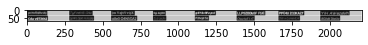

In [20]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)